In [153]:
%load_ext autoreload
%autoreload 2
import pymc4 as pm
import tensorflow as tf
from tensorflow_probability import bijectors
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Linear Regression

In [181]:
# Logp calculation for linear regression 
@pm.model(auto_name=True)
def linreg(n_points=100):
    # Define priors
    sigma = pm.HalfNormal(sigma=1.)
    intercept = pm.Normal(mu=0, sigma=.1)
    x_coeff = pm.Normal(mu=0, sigma=1.)
    x = np.linspace(-5, 5, n_points)
    # Define likelihood
    y = pm.Normal(mu=intercept + x_coeff * x, sigma=sigma)

model = linreg.configure()

forward_sample = model.forward_sample()

model = model.observe(y=forward_sample['y'])

In [182]:
forward_sample['x_coeff']

<tf.Tensor: id=9278362, shape=(), dtype=float32, numpy=-1.1457194>

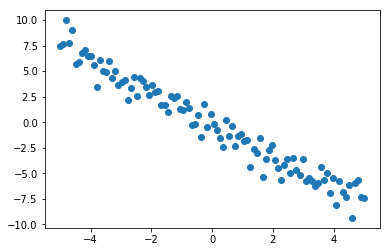

In [183]:
plt.scatter(np.linspace(-5, 5, 100), forward_sample['y'])

In [184]:
trace, stats = model.sample_posterior(samples=2000, 
                                      tuning=1000,
                                      step_size=1e-6,
                                     )

/Users/twiecki/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


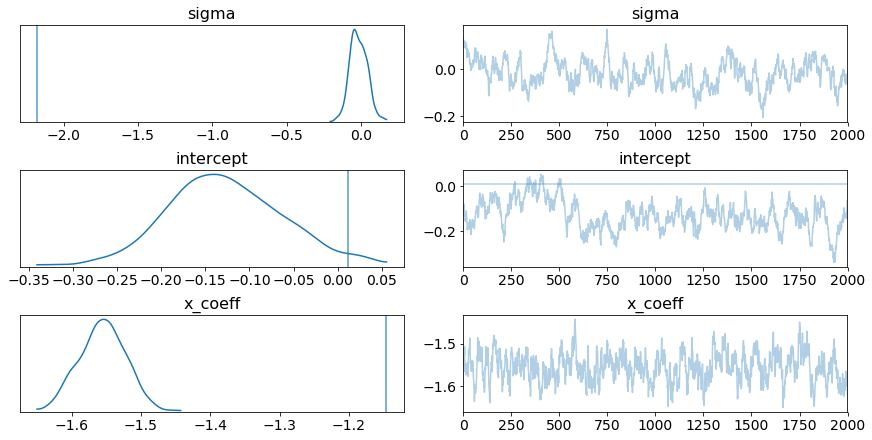

In [185]:
import arviz as az
az.plot_trace(trace, lines=(
    ('x_coeff', {}, [forward_sample['x_coeff']]),
    ('sigma', {}, [forward_sample['sigma']]),
    ('intercept', {}, [forward_sample['intercept']]),
));

# Centered-Eight 

In [149]:
schools = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.], 
                   dtype='float32')
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.], 
                 dtype='float32')
n_points = 8

@pm.model(auto_name=True)
def centered_eight(n_points=n_points):    
    # Define priors
    mu = pm.Normal(mu=0, sigma=5)
    tau = pm.HalfNormal(sigma=1.)
    eta = pm.Normal(mu=tf.zeros(8), sigma=tf.ones(8))
    theta = mu + eta * tau
    # Define likelihood
    y = pm.Normal(mu=theta, sigma=sigma)
    
model = centered_eight.configure().observe(y=schools)

In [150]:
model.forward_sample()

{'mu': <tf.Tensor: id=8381949, shape=(), dtype=float32, numpy=-6.2605567>,
 'tau': <tf.Tensor: id=8381997, shape=(), dtype=float32, numpy=0.6708447>,
 'eta': <tf.Tensor: id=8382044, shape=(8,), dtype=float32, numpy=
 array([-0.20429681, -0.6022477 , -0.4017432 , -0.36755568,  0.71968806,
         0.28262165, -2.1404436 ,  0.54873514], dtype=float32)>,
 'y': <tf.Tensor: id=8382091, shape=(8,), dtype=float32, numpy=
 array([  3.9984503,  -8.990461 , -17.499084 ,  -5.966687 ,  -2.3471289,
        -15.902113 , -15.370098 ,  -2.4322352], dtype=float32)>}

In [152]:
trace, _ = model.sample_posterior(1000, tuning=2000, step_size=1e-4)

/Users/twiecki/anaconda3/lib/python3.6/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


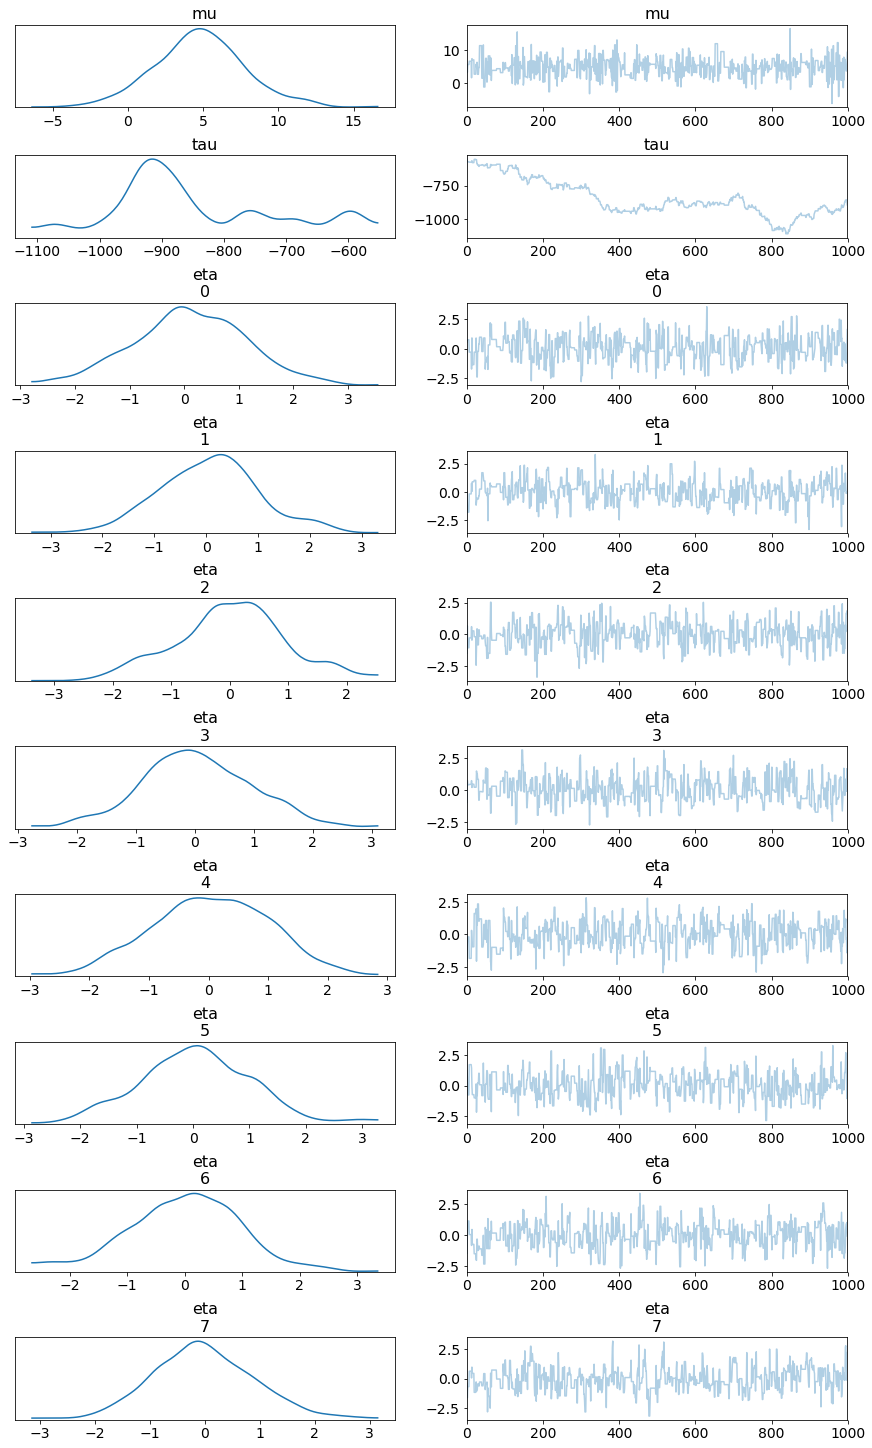

In [148]:
az.plot_trace(trace);